# Amazon Sentiment Analysis

We will create a sentiment analysis based on the amazon reviews dataset. https://www.kaggle.com/datasets/bittlingmayer/amazonreviews In the dataset there are 2 labels:
- label 1 which denotes bad reviews (1 star and 2 star reviews)
- label 2 which denotes good reviews (4 and 5-star reviews)
- 3 star reviews were not included in the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import confusion_matrix, classification_report
import re
import pickle

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.optim as optim

from transformers import RobertaForSequenceClassification, AlbertForSequenceClassification
from transformers import ElectraForSequenceClassification, XLNetForSequenceClassification
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


## Load data

In [2]:
path = '/content/Dataset, train, balanced, Amazon reviews 100.csv'
df = pd.read_csv(path)
df.head(5)


,label,text
0,0,"Buyer beware: This is a self-published book, a..."
1,0,The Worst!: A complete waste of time. Typograp...
2,0,Oh please: I guess you have to be a romance no...
3,0,Awful beyond belief!: I feel I have to write t...
4,0,Don't try to fool us with fake reviews.: It's ...


In [3]:
print(len(df))

100


In [4]:
print(df['label'].value_counts())

label
0    50
1    50
Name: count, dtype: int64


# Preprocessing
I am going to prepera dataset by applying to it the following functions:

 - Lowercasing
 - remove punctuation
 - remove stopwords
 - tokenization
 - remove empty rows
 - lammatization
 - n-grams
 - embeddings
 - concatonate tokenize and embeded fetures with embeded 2-grams of the input sequences
 - padding

### Lowercase

In [5]:
def lowercase(df):
    df['text'] = df['text'].str.lower()
    return df

### Punctuation

In [6]:
def remove_punctuation(df):
    # Define a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', string.punctuation)
    df['text'] = df['text'].apply(lambda x: x.translate(translator))
    return df

### Stopwords

In [7]:
def ensure_nltk_data():
     try:
         stop_words = set(stopwords.words('english'))
     except LookupError:
         nltk.download('stopwords')
         stop_words = set(stopwords.words('english'))

     try:
         nltk.data.find('tokenizers/punkt')
     except LookupError:
         nltk.download('punkt')

ensure_nltk_data()
# load the set of stopwords
stop_words = set(stopwords.words('english'))

#check if we get stopwords
a = 0
for w in stop_words:
    print(w)
    a += 1
    if a == 5:
        break

each
my
over
up
to


In [8]:
 def remove_stopwords(cell):
     words = cell.split()
     filtered_words = [w for w in words if w not in stop_words]
     return ' '.join(filtered_words)

### Tokenize

In [9]:
def tokenize(cell):
    return word_tokenize(cell)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Empty rows

In [10]:
def remove_empty_rows(df):
    def is_not_empty(cell):
        # Check if the cell is a list and it is not empty
        if isinstance(cell, list) and len(cell) > 0:
            # Check if all nested lists within the cell are also not empty
            for item in cell:
                if isinstance(item, list) and len(item) == 0:
                    return False
            return True
        return False

    df = df[df['text'].apply(is_not_empty) & df['2-grams'].apply(is_not_empty)]
    return df

### Lammatize

In [11]:
# Ensure necessary NLTK data files are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(tokens):
    """Lemmatize a list of tokens"""
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### N-grams

In [12]:
def generate_ngrams(text_tokens, n):
    """Generate n-grams from a list of tokens."""
    ngrams = [' '.join(text_tokens[i:i+n]) for i in range(len(text_tokens)-n+1)]
    return ngrams

def add_ngrams_column(df, n=2):
    """Add a column of n-grams to the DataFrame."""
    df[f'{n}-grams'] = df['text'].apply(lambda x: generate_ngrams(x, n))
    return df

### Embeddings

In [13]:
file_path_embeddings = '/content/glove.6B.100d.txt'

def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def get_embedding(word, embeddings):
    return embeddings.get(word, None)

embeddings = load_glove_embeddings(file_path_embeddings)

In [14]:
# get dynamically embedding dim
first_word = next(iter(embeddings))
embedding_dim = len(embeddings[first_word])

In [15]:
# this function checks if we are working with tokens or 2-grams and appropriatly handles embeddings for each case
def embed(cell):
    vectors = []
    for t in cell:
        if ' ' in t:  # Check if it's a 2-gram
            tokens = t.split()
            token_vectors = []
            for token in tokens:
                vector = get_embedding(token, embeddings)
                if vector is not None:
                    token_vectors.append(vector)
            if token_vectors:
                # Average the token vectors to maintain the same dimensionality
                averaged_vector = np.mean(token_vectors, axis=0)
                vectors.append(averaged_vector)
        else:  # Single token case
            vector = get_embedding(t, embeddings)
            if vector is not None:
                vectors.append(vector)
    return vectors

### concatonate features

In [16]:
def create_vector_column(df):
    def concatenate_vectors(row):
        text_vectors = row['text']
        ngram_vectors = row['2-grams']

        # Convert lists to numpy arrays
        text_vectors = np.array(text_vectors)
        ngram_vectors = np.array(ngram_vectors)

        # Check if both arrays have the same embedding size
        if text_vectors.shape[1] != ngram_vectors.shape[1]:
            raise ValueError("Embedding sizes of text vectors and n-gram vectors do not match.")

        # Concatenate along the first axis (sequence length)
        combined_vectors = np.concatenate((text_vectors, ngram_vectors), axis=0)
        return combined_vectors

    df['vector'] = df.apply(concatenate_vectors, axis=1)
    return df

### Remove unnecesary columns

In [17]:
def remove_columns(df):
    df.drop('text', axis=1, inplace=True)
    df.drop('2-grams', axis=1, inplace=True)
    return df

### Pading

In [18]:
def pad_sequences_to_uniform_length(df, column_name, embedding_size):
    # Find the length of the longest sequence
    max_length = max(df[column_name].apply(len))

    def pad_sequence(seq, length, embedding_size):
        seq = np.array(seq)

        # Handle empty sequences or improperly shaped sequences
        if len(seq.shape) == 0 or (len(seq.shape) == 1 and seq.shape[0] == 0):
            return np.zeros((length, embedding_size))

        # Ensure sequence is two-dimensional
        if len(seq.shape) == 1:
            seq = np.expand_dims(seq, axis=0)
        elif len(seq.shape) > 2:
            seq = np.squeeze(seq)


        # Ensure seq has correct shape (n, embedding_size)
        if seq.shape[1] != embedding_size:
            print(f"Processing sequence with shape: {seq.shape}")
            print(f"Expected embedding size: {embedding_size}")
            raise ValueError(f"Sequence has incorrect embedding size. Expected {embedding_size}, got {seq.shape[1]}")

        # Calculate how much padding is needed
        padding_needed = length - len(seq)
        # Pad sequence with zeros
        padded_seq = np.pad(seq, ((0, padding_needed), (0, 0)), mode='constant')

        return padded_seq

    # Pad all sequences to the uniform length
    df[column_name] = df[column_name].apply(lambda x: pad_sequence(x, max_length, embedding_size))

    return df

## preprocessing function

In [19]:
def preprocess_df(df):
    df = lowercase(df)
    df = remove_punctuation(df)
    df['text'] = df['text'].apply(remove_stopwords)
    df['text'] = df['text'].apply(tokenize)
    df['text'] = df['text'].apply(lemmatize)
    df = add_ngrams_column(df, n=2)
    df['2-grams'] = df['2-grams'].apply(embed)
    df['text'] = df['text'].apply(embed)
    df = remove_empty_rows(df)
    df = create_vector_column(df)
    df = remove_columns(df)
    df = pad_sequences_to_uniform_length(df, 'vector', embedding_dim)

    return df

# Load Data

In [45]:
path_dataset = '/content/Dataset, train, balanced, Amazon reviews 100000.csv'

df = pd.read_csv(path_dataset)
len(df)


100000

In [46]:
df = preprocess_df(df)

In [47]:
# Save the preprocessed dataset to a new CSV file
preprocessed_dataset_path = '/content/Processed_Dataset_100.pkl'
with open(preprocessed_dataset_path, 'wb') as file:
    pickle.dump(df, file)

print(f"Preprocessed dataset saved to: {preprocessed_dataset_path}")

Preprocessed dataset saved to: /content/Processed_Dataset_100.pkl


In [43]:
# Loading the preprocessed DataFrame
preprocessed_dataset_path = '/content/Processed_Dataset_100000.pkl'
with open(preprocessed_dataset_path, 'rb') as file:
    df = pickle.load(file)

print(f"Preprocessed dataset loaded from: {preprocessed_dataset_path}")

Preprocessed dataset loaded from: /content/Processed_Dataset_100000.pkl


In [48]:
len(df)

100000

In [49]:
print("Type of preprocess_df:", type(df))
df.head(5)

Type of preprocess_df: <class 'pandas.core.frame.DataFrame'>


,label,vector
0,0,"[[0.43935, 0.23369, 0.71307, 0.085834, 0.34873..."
1,0,"[[0.39456, -0.24717, 1.0319, -0.61444, -1.2376..."
2,0,"[[-0.66665, 0.43269, 1.3134, -0.82401, -0.4911..."
3,0,"[[0.022472, 0.20923, 0.55412, -0.70121, -0.964..."
4,0,"[[0.0024119, 0.50144, 0.16453, -0.23827, -1.33..."


### Checks

In [50]:
print("Type of preprocess_df:", type(df))
print(df.iloc[99])

Type of preprocess_df: <class 'pandas.core.frame.DataFrame'>
label                                                     0
vector    [[-0.23317, 0.36893, 0.028304, 0.22558, -0.000...
Name: 99, dtype: object


In [25]:
df.head(5)

,label,vector
0,0,"[[0.43935, 0.23369, 0.71307, 0.085834, 0.34873..."
1,0,"[[0.39456, -0.24717, 1.0319, -0.61444, -1.2376..."
2,0,"[[-0.66665, 0.43269, 1.3134, -0.82401, -0.4911..."
3,0,"[[0.022472, 0.20923, 0.55412, -0.70121, -0.964..."
4,0,"[[0.0024119, 0.50144, 0.16453, -0.23827, -1.33..."


In [51]:
print(df.dtypes)

label      int64
vector    object
dtype: object


In [52]:
def check_vector_shapes(df, column_name='vector'):
    shapes = df[column_name].apply(lambda x: np.array(x).shape)
    first_shape = shapes.iloc[0]
    consistent = all(shape == first_shape for shape in shapes)

    if consistent:
        print("All vectors have the same shape:", first_shape)
    else:
        print("Inconsistent vector shapes found.")
        print(shapes.value_counts())

    return consistent

consistent_shapes = check_vector_shapes(df, 'vector')

All vectors have the same shape: (267, 100)


# Dataset

In [53]:
class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        vector = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 0]
        vector = self.normalize(vector)
        return vector, label

    def normalize(self, vector):
        # Convert nested numpy arrays to a torch tensor
        text_tensor = torch.tensor(vector, dtype=torch.float32)
        if text_tensor.numel() == 0:
            return text_tensor  # Return as-is if empty

        # Flatten the tensor to apply normalization
        original_shape = text_tensor.shape
        text_tensor = text_tensor.view(-1, text_tensor.size(-1))

        # Normalize along the last dimension (columns of each vector)
        mean = text_tensor.mean(dim=0, keepdim=True)
        std = text_tensor.std(dim=0, keepdim=True)

        # Avoid division by zero
        std[std == 0] = 1  # Replace zero std with 1 to avoid NaNs

        normalized_text = (text_tensor - mean) / std

        # Reshape back to the original nested structure
        normalized_text = normalized_text.view(original_shape)
        return normalized_text

In [54]:
dataset = MyDataset(df)

# Define proportions for training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
dataset_train, dataset_val, dataset_test = random_split(dataset, [train_size, val_size, test_size])

### Checks

In [55]:
print(dataset_train.__len__())
print(dataset_val.__len__())
print(dataset_test.__len__())

80000
10000
10000


In [56]:
x, y = dataset_train.__getitem__(10)
print(x.shape, y.shape)
print(x)
print(y)

torch.Size([267, 100]) ()
tensor([[ 0.0170,  0.2468,  1.3773,  ...,  2.6742, -1.4901,  0.8159],
        [ 2.0696,  0.9104,  0.7172,  ...,  1.5340, -1.0140,  2.6390],
        [-0.5522,  1.5129,  0.4459,  ..., -0.9577,  0.1720,  1.0405],
        ...,
        [ 0.0502, -0.3097, -0.4149,  ...,  0.2828, -0.4170, -0.3630],
        [ 0.0502, -0.3097, -0.4149,  ...,  0.2828, -0.4170, -0.3630],
        [ 0.0502, -0.3097, -0.4149,  ...,  0.2828, -0.4170, -0.3630]])
0


In [57]:
def check_balance(df):
    count_of_ones = 0
    count_of_zeros = 0
    for i in range(0,df.__len__()):
        x, y = df.__getitem__(i)
        if y == 1:
            count_of_ones += 1

        if y == 0:
            count_of_zeros += 1

    return print(f' count of ones: {count_of_ones}, count of zeros: {count_of_zeros}')

print(check_balance(dataset_train))
print(check_balance(dataset_val))
print(check_balance(dataset_test))

 count of ones: 39915, count of zeros: 40085
None
 count of ones: 5071, count of zeros: 4929
None
 count of ones: 5014, count of zeros: 4986
None


In [58]:
def get_unique_shapes(dataset):
    shapes = []
    for i in range(len(dataset)):
        x, _ = dataset[i]
        shapes.append(x.shape[0])
    return set(shapes)

def check_shape(df_train, df_val, df_test):
    unique_shapes_train = get_unique_shapes(df_train)
    unique_shapes_val = get_unique_shapes(df_val)
    unique_shapes_test = get_unique_shapes(df_test)

    print(unique_shapes_train, unique_shapes_val, unique_shapes_test)

In [59]:
check_shape(dataset_train, dataset_val, dataset_test)

{267} {267} {267}


# Neural Network

In [60]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bidirectional, num_layers, dropout):
        super(LSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.dropout = dropout

        self.norm = nn.BatchNorm1d(input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, x):
        batch_size, seq_len, input_dim = x.size()
        x = x.view(batch_size * seq_len, input_dim)     # Reshape x for batch normalization
        x = self.norm(x)                                # Normalize batch
        x = x.view(batch_size, seq_len, input_dim)      # Reshape x back to (batch_size, seq_len, input_dim)
        h0, c0 = self.hidden_init(batch_size)           # Initialize hidden state and cell state
        out, _ = self.lstm(x, (h0, c0))                 # LSTM forward pass
        out = self.fc(out[:, -1, :])                    # Fully connected layer (take the last time step output)
        return out

    def hidden_init(self, batch_size):
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return h0, c0

# Train, val and test functions

In [91]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, grad_clip_value):
    model.train()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()

            if torch.isnan(outputs).any():
                print("NaNs found in outputs")
                continue

            loss = criterion(outputs, targets)

            if torch.isnan(loss):
                print("NaNs found in loss")
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_value)
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

        val_loss = validate_model(model, val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Model loaded with the best validation loss state.")

def validate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()
            outputs = model(inputs).squeeze()

            if torch.isnan(outputs).any():
                print("NaNs found in validation outputs")
                continue

            loss = criterion(outputs, targets)

            if torch.isnan(loss):
                print("NaNs found in validation loss")
                continue

            val_loss += loss.item()

    val_loss /= len(val_loader)
    model.train()
    return val_loss

# Run the model

## Hyperparameters

In [109]:
batch_size = 32
input_dim = embedding_dim   # The number of input features per time step. This corresponds to the dimensionality of the input vectors
hidden_dim = 256       # The number of features in the hidden state of the LSTM. It defines the internal state representation size of the LSTM. Higher values allow the LSTM to capture more complex patterns but also increase the computational cost.
output_dim = 1
num_layers = 2
dropout = 0.2
num_epochs = 15
learning_rate = 0.01
grad_clip_value = 1.0  # Example gradient clipping value

## Initialize

In [93]:
model = LSTM(input_dim, hidden_dim, output_dim, num_layers=num_layers, bidirectional=True, dropout=dropout)

In [94]:
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [95]:
def print_batch_dimensions(data_loader, loader_name):
    for batch_idx, (data, target) in enumerate(data_loader):
        print(f"{loader_name} - Batch {batch_idx + 1} dimensions:")
        print(f"Data shape: {data.shape}")
        print(f"Target shape: {target.shape}")
        break  # Remove this break to check all batches

print_batch_dimensions(train_loader, "Training")

Training - Batch 1 dimensions:
Data shape: torch.Size([32, 267, 100])
Target shape: torch.Size([32])


### Find best lr

In [96]:
def find_optimal_lr(model, train_loader, start_lr=1e-7, end_lr=1.0, num_iter=100, steps_per_lr=3):
    model.train()

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=start_lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=(end_lr/start_lr)**(1/num_iter))

    lrs = []
    losses = []

    data_iter = iter(train_loader)
    for i in range(num_iter):
        total_loss = 0.0
        for _ in range(steps_per_lr):
            try:
                inputs, targets = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                inputs, targets = next(data_iter)

            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Ensure the output shape matches the target shape
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()

        avg_loss = total_loss / steps_per_lr
        current_lr = optimizer.param_groups[0]['lr']

        lrs.append(current_lr)
        losses.append(avg_loss)

        print(f"Iteration [{i + 1}/{num_iter}], Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

    # Plotting the learning rate vs. loss
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Range Test')
    plt.show()

    # Find the best learning rates
    lr_loss_pairs = sorted(zip(losses, lrs))
    best_lrs = [lr for loss, lr in lr_loss_pairs[:5]]  # Get the 5 learning rates with the lowest losses

    return lrs, losses, best_lrs

Iteration [1/100], Loss: 0.6902, LR: 0.000000
Iteration [2/100], Loss: 0.6869, LR: 0.000000
Iteration [3/100], Loss: 0.6891, LR: 0.000000
Iteration [4/100], Loss: 0.6952, LR: 0.000000
Iteration [5/100], Loss: 0.6965, LR: 0.000000
Iteration [6/100], Loss: 0.6904, LR: 0.000000
Iteration [7/100], Loss: 0.6920, LR: 0.000000
Iteration [8/100], Loss: 0.6919, LR: 0.000000
Iteration [9/100], Loss: 0.6958, LR: 0.000000
Iteration [10/100], Loss: 0.6942, LR: 0.000001
Iteration [11/100], Loss: 0.6931, LR: 0.000001
Iteration [12/100], Loss: 0.6943, LR: 0.000001
Iteration [13/100], Loss: 0.6967, LR: 0.000001
Iteration [14/100], Loss: 0.6958, LR: 0.000001
Iteration [15/100], Loss: 0.6957, LR: 0.000001
Iteration [16/100], Loss: 0.6887, LR: 0.000001
Iteration [17/100], Loss: 0.6903, LR: 0.000002
Iteration [18/100], Loss: 0.6962, LR: 0.000002
Iteration [19/100], Loss: 0.6928, LR: 0.000002
Iteration [20/100], Loss: 0.6939, LR: 0.000003
Iteration [21/100], Loss: 0.6899, LR: 0.000003
Iteration [22/100], Lo

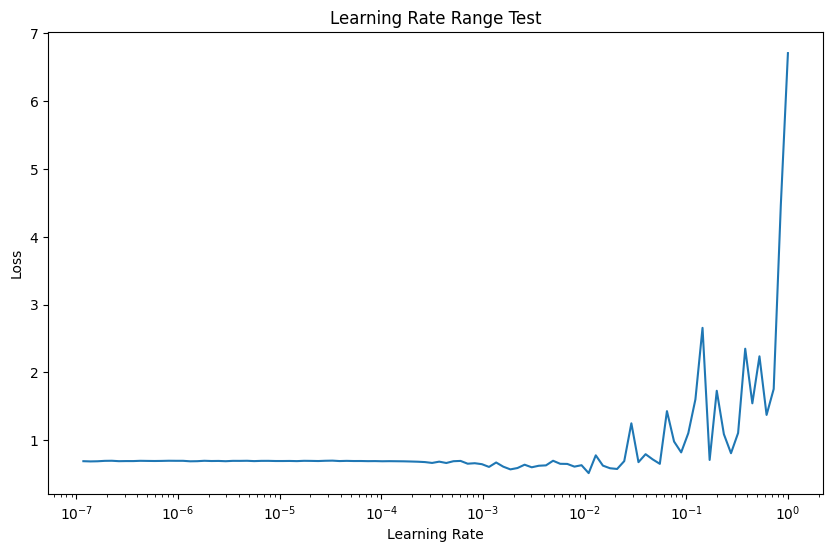

The best learning rate is: [0.010964781961431832, 0.0018620871366628643, 0.020892961308540358, 0.017782794100389198, 0.002187761623949549]


In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

lrs, losses, best_lr = find_optimal_lr(model, train_loader)

print(f"The best learning rate is: {best_lr}")

In [98]:
print(best_lr)

[0.010964781961431832, 0.0018620871366628643, 0.020892961308540358, 0.017782794100389198, 0.002187761623949549]


In [110]:
# best lr 0.002187761623949549
learning_rate = best_lr[4]

## Train

In [ ]:
train_model(model, train_loader, val_loader, num_epochs, learning_rate, grad_clip_value)

# Test the model

In [104]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Turn off gradients for evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get binary predictions
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Compute confusion matrix
    cm = confusion_matrix(all_targets.numpy(), all_preds.numpy())
    print("Confusion Matrix:")
    print(cm)

    # Compute classification report
    report = classification_report(all_targets.numpy(), all_preds.numpy(), target_names=['Class 0', 'Class 1'])
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



Confusion Matrix:
[[3969 1017]
 [ 652 4362]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.80      0.83      4986
     Class 1       0.81      0.87      0.84      5014

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



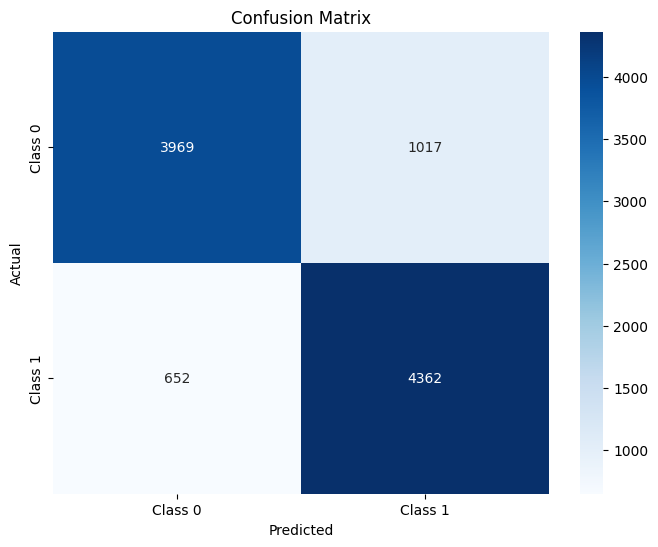

In [105]:
# Example usage
test_model(model, test_loader)

# Save model

In [107]:
def save_model_architecture(model, filepath):
    model_architecture = {
        'class_name': model.__class__.__name__,
        'input_dim': model.input_dim,
        'hidden_dim': model.hidden_dim,
        'output_dim': model.output_dim,
        'bidirectional': model.bidirectional,
        'num_layers': model.num_layers,
        'dropout': model.dropout
    }
    torch.save(model_architecture, filepath)
    print(f"Model architecture saved to {filepath}")

def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model weights saved to {filepath}")


In [108]:
architecture_path = 'model_architecture.pth'
save_model_architecture(model, architecture_path)

weights_path = 'model_weights.pth'
save_model_weights(model, weights_path)

Model architecture saved to model_architecture.pth
Model weights saved to model_weights.pth
